**RMSF Analyis of MD Simulations**

In this notebook, we will perform Root Mean Square Fluctuation (RMSF) analysis for LAT1 residues, with cholesterol bound to to the CHOL3 site. For access to the MD files used in this notebook, please refer to Zenodo (linked in the repository README file).

This analysis visualizes the fluctuations of the positions of Cα atoms of LAT1 residues from the initial structure. We highlight the transmembrane helices (TMs), showing that most of the protein’s flexibility occurs in the loop regions of the protein. See the paper for more discussion on this.

This notebook focuses on the RMSF for the four replicate systems at the CHOL3 cholesterol binding site.

In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

**1. Load Trajectories for CHOL3**

Here, we load the MD trajectories and topology files for four replicates of LAT1 interacting with cholesterol at the CHOL3 binding site.

Each replicate was run independently, allowing us to assess the consistency of RMSF across replicate 200ns simulation runs.

In [3]:
# Load the trajectory and topology files for four replicate systems of CHOL3
u31 = mda.Universe('../Files/CHOL3/clr3_md1.pdb', '../Files/CHOL3/clr3_md1.xtc')
u32 = mda.Universe('../Files/CHOL3/clr3_md2.pdb', '../Files/CHOL3/clr3_md2.xtc')
u33 = mda.Universe('../Files/CHOL3/clr3_md3.pdb', '../Files/CHOL3/clr3_md3.xtc')
u34 = mda.Universe('../Files/CHOL3/clr3_md4.pdb', '../Files/CHOL3/clr3_md4.xtc')

# Group the universes in a list for easy processing
chol3_replicates = [u31, u32, u33, u34]

**2. Define the Transmembrane (TM) Helix**

In this work, I was really interested in seeing what regions of the protein are stable in response to cholesterol interactions. Therefore, highlighting all the TMs was an aspect I honed in on. In other contexts, different regions could be of interest, so this code can easily be adjusted to suit.

In [4]:
# Define the TM regions with their residue ranges
tm_regions = {
    'TM1a': '52:63',
    'TM1b': '71:79',
    'TM2': '82:114',
    'TM3': '127:160',
    'TM4': '168:187',
    'TM5': '190:220',
    'TM6a': '240:254',
    'TM6b': '260:267',
    'TM7': '273:299',
    'TM8': '323:356',
    'TM9': '374:387',
    'TM10': '393:421',
    'TM11': '433:452',
    'TM12': '457:478'
}

# Use this handy helper function to parse residue ranges
def parse_resid_range(resid_range):
    start, end = resid_range.split(':')
    return int(start), int(end)

**3. Calculate RMSF and Visualize data across replicate MD runs**

We can calculate RMSF using the following steps:
1. **Aligning Trajectories**: We align the MD trajectory to a reference structure (the average structure over the trajectory) to eliminate overall translational and rotational motion.
2. **RMSF Calculation**: We compute the RMSF for each Cα atom in the protein, measuring the fluctuations from the average structure.

The `calculate_rmsf()` below function implements this by first aligning the protein and then calculating the fluctuations. See MDAnalysis documentation for a more thorough description of RMSF calculation. 

In [5]:
# Function to calculate RMSF for each replicate
def calculate_rmsf(u):
    average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
    ref = average.results.universe
    aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()
    c_alphas = u.select_atoms('protein and name CA')
    rmsf = rms.RMSF(c_alphas).run()
    return c_alphas.resids, rmsf.results.rmsf  # Return residue numbers and RMSF values

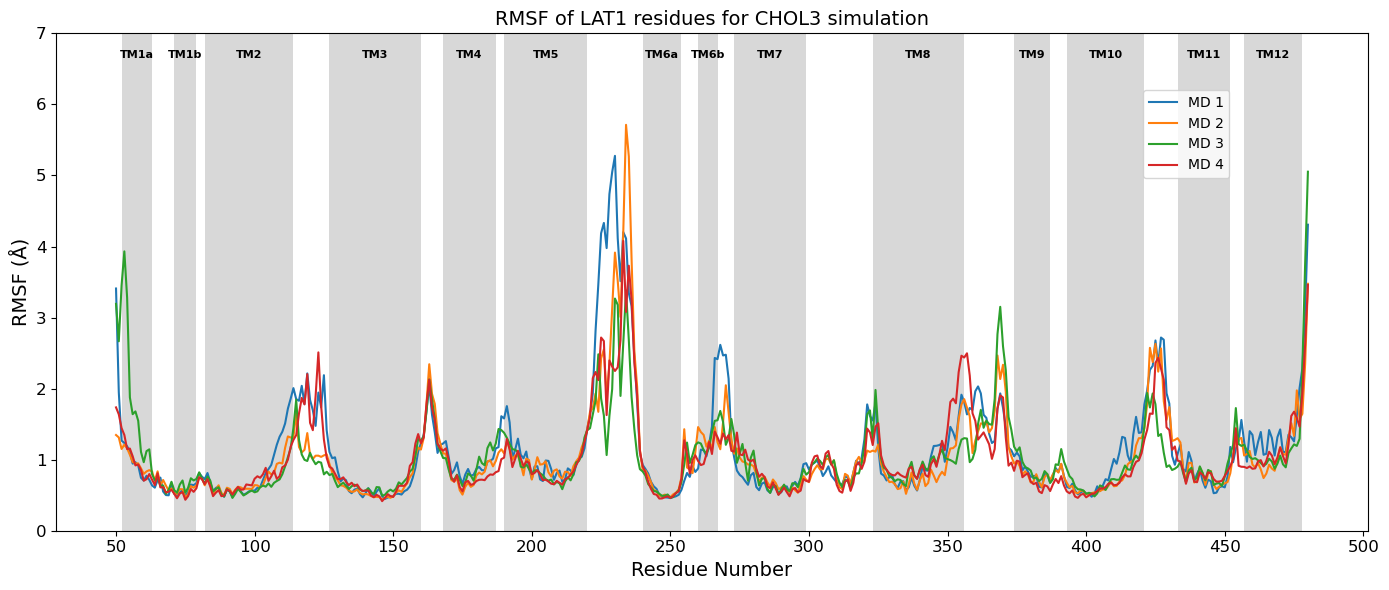

In [6]:
# Set global plot parameters 
title_fontsize = 14
axis_label_fontsize = 14
tick_label_fontsize = 12
legend_fontsize = 10
global_min_rmsf = 0
global_max_rmsf = 7  # Set y-axis limits. Adjust based on flexibity expected

# Create a figure for RMSF plot across replicates
fig, ax = plt.subplots(figsize=(14, 6))

# Plot RMSF for each replicate
lines = []  # Store line objects for legend
labels = []  # Store labels for legend

for idx, u in enumerate(chol3_replicates):
    resids, rmsf_values = calculate_rmsf(u)
    line, = ax.plot(resids, rmsf_values, linewidth=1.5, label=f'Replicate {idx + 1}')
    lines.append(line)
    labels.append(f'MD {idx + 1}')

# Add TM regions to the plot (highlight regions of transmembrane helices)
for tm, resid_range in tm_regions.items():
    start, end = parse_resid_range(resid_range)
    ax.axvspan(start, end, color='grey', alpha=0.3, lw=0)  # Highlight TM regions
    mid_resid = (start + end) / 2  # Find the middle of the TM region to place the label
    ax.text(mid_resid, global_max_rmsf * 0.95, tm, horizontalalignment='center', fontsize=8, color='black', fontweight='bold')

# Customize plot appearance
ax.set_title('RMSF of LAT1 residues for CHOL3 simulation', fontsize=title_fontsize)
ax.set_xlabel('Residue Number', fontsize=axis_label_fontsize)
ax.set_ylabel('RMSF (Å)', fontsize=axis_label_fontsize)
ax.set_xticks(np.arange(50, 501, 50))
ax.set_ylim(global_min_rmsf, global_max_rmsf)
ax.tick_params(axis='both', labelsize=tick_label_fontsize)

# Add legend
ax.legend(lines, labels, fontsize=legend_fontsize, loc='best', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout()
plt.show()

The plot above shows the RMSF values for LAT1 residues across the four replicate simulations. The x-axis represents the residue number, and the y-axis shows the RMSF (Å).

Additionally, highlighting the transmembrane (TM) regions within the protein, with shaded areas and labels, makes it easy to see where the protein is more flexible and more rigid.

Higher RMSF values indicate residues that fluctuate more during the simulation, which is typically seen in loop regions(ex: Loop connecting TM5 & TM6a), while lower RMSF values correspond to more stable regions (ex: TM2).